In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import yfinance as yf
import scipy.stats as stats
import datetime
import time
import requests
import io

import warnings
warnings.filterwarnings('ignore')

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.5) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Give the Name of Stock

In [2]:
Symbols = ['GOOGL']

In [3]:
#Function to download Data From Yahoo Finance
def download_data(start,end):
    stock_final = pd.DataFrame()
    # iterate over each symbol
    for i in Symbols:  

        # print the symbol which is being downloaded
        print( str(Symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  

        try:
            # download the stock price 
            stock = []
            stock = yf.download(i,start=start, end=end, progress=False)
            # append the individual stock prices 
            if len(stock) == 0:
                None
            else:
                stock['Name']=i
                stock_final = stock_final.append(stock,sort=False)
        except Exception:
            None
    return stock_final

In [4]:
#Give the start and End Time duration of Train and Test Data
train_start = datetime.datetime(2007,1,1)
train_end = datetime.datetime(2018,1,1)
test_start = datetime.datetime(2018,1,1)
test_end = datetime.datetime(2020,1,1)

In [26]:
#Call The Functio
df_train = download_data(train_start,train_end)
df_test = download_data(test_start,test_end)

0 : GOOGL,0 : GOOGL,

In [6]:
df_train.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2007-01-03,233.233231,238.568573,230.785782,234.029022,234.029022,15397587,GOOGL
2007-01-04,234.734741,242.217224,234.409409,241.871872,241.871872,15759425,GOOGL
2007-01-05,241.491486,243.993988,239.294296,243.838837,243.838837,13730456,GOOGL
2007-01-08,244.089096,245.180176,241.341339,242.032028,242.032028,9499291,GOOGL
2007-01-09,242.967972,244.369370,240.840836,242.992996,242.992996,10752037,GOOGL


In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2769 entries, 2007-01-03 to 2017-12-29
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2769 non-null   float64
 1   High       2769 non-null   float64
 2   Low        2769 non-null   float64
 3   Close      2769 non-null   float64
 4   Adj Close  2769 non-null   float64
 5   Volume     2769 non-null   int64  
 6   Name       2769 non-null   object 
dtypes: float64(5), int64(1), object(1)
memory usage: 173.1+ KB


##### Training Data is from 2007 till 2018

## The Time Series Plot

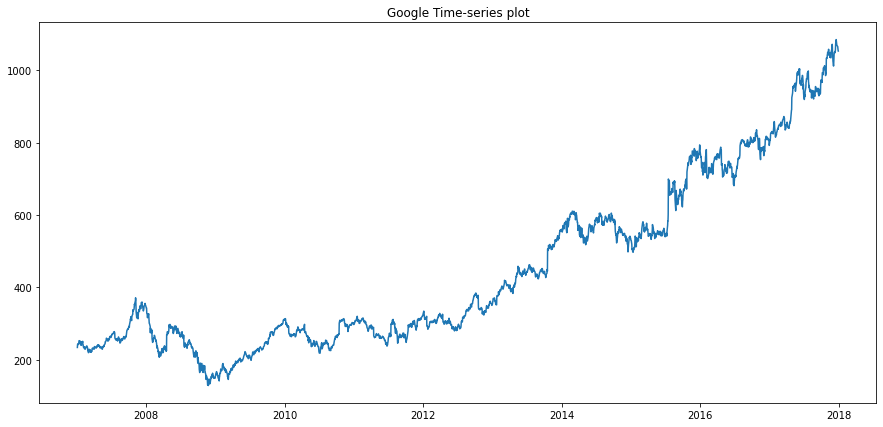

In [8]:
plt.figure(figsize=(15,7))
plt.plot(df_train.Close)
plt.title('Google Time-series plot')
plt.show()

## Preprocessing

In [9]:
df_train.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Name'], dtype='object')

In [10]:
#We will use close price as a Target and drop rest of the columns
df_train = df_train.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Name'],axis=1)

### Normalize the Dataset

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

df_train_scaled = scaler.fit_transform(df_train)

### Creating Time-Step

In [12]:
#Creating Data Stricture with 60 time-steps 
#60 time-step means we will try to predict on the basis of past 60 days of historical data

time_step = 60

X_train = []

y_train = []

for i in range(time_step,len(df_train_scaled)):
    
    X_train.append(df_train_scaled[i-time_step:i,0])
    
    y_train.append(df_train_scaled[i,0])

X_train,y_train = np.array(X_train),np.array(y_train)

In [13]:
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_train.shape,y_train.shape

((2709, 60, 1), (2709,))

## Model

In [14]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,LSTM,Dropout

In [15]:
def LSTM_model():
    
    model = Sequential()

    #First LSTM layer
    model.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1],1)))
    model.add(Dropout(0.2))

    #Second LSTM Layer
    model.add(LSTM(units = 64, return_sequences = True))
    model.add(Dropout(0.2))

    #Third LSTM Layer
    model.add(LSTM(units = 64, return_sequences = True))
    model.add(Dropout(0.2))
    
    #Forth LSTM Layer
    model.add(LSTM(units = 64))
    model.add(Dropout(0.2))
    

    #Output Layer(Dense)
    model.add(Dense(units=1))

    return model

In [16]:
model = LSTM_model()
model.compile(optimizer='adam',loss='mean_squared_error',metrics=['mean_squared_error',  'cosine_proximity'])

earlystopping=EarlyStopping(monitor="mean_squared_error", patience=5, verbose=1, mode='auto')

model.fit(X_train,y_train,epochs = 15,validation_split = 0.1, batch_size = 16,callbacks=[earlystopping])

Epoch 1/15
153/153 [==============================] - 18s 83ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - cosine_proximity: 0.9873 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_cosine_proximity: 1.0000
Epoch 2/15
153/153 [==============================] - 13s 85ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - cosine_proximity: 0.9996 - val_loss: 0.0044 - val_mean_squared_error: 0.0044 - val_cosine_proximity: 1.0000
Epoch 3/15
153/153 [==============================] - 12s 81ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - cosine_proximity: 0.9979 - val_loss: 0.0011 - val_mean_squared_error: 0.0011 - val_cosine_proximity: 1.0000
Epoch 4/15
153/153 [==============================] - 11s 70ms/step - loss: 0.0012 - mean_squared_error: 0.0012 - cosine_proximity: 0.9979 - val_loss: 0.0054 - val_mean_squared_error: 0.0054 - val_cosine_proximity: 1.0000
Epoch 5/15
153/153 [==============================] - 12s 82ms/step - loss: 0.0011 - mean_squared_error: 0.0011 

In [17]:
#Saving The Model
model.save('time_series_lstm.h5')

### Test our Model on Test Set

In [27]:
print(df_test.info())
df_test.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2018-01-02 to 2019-12-31
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       503 non-null    float64
 1   High       503 non-null    float64
 2   Low        503 non-null    float64
 3   Close      503 non-null    float64
 4   Adj Close  503 non-null    float64
 5   Volume     503 non-null    int64  
 6   Name       503 non-null    object 
dtypes: float64(5), int64(1), object(1)
memory usage: 31.4+ KB
None


,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2018-01-02,1053.020020,1075.979980,1053.020020,1073.209961,1073.209961,1588300,GOOGL
2018-01-03,1073.930054,1096.099976,1073.430054,1091.520020,1091.520020,1565900,GOOGL
2018-01-04,1097.089966,1104.079956,1094.260010,1095.760010,1095.760010,1302600,GOOGL
2018-01-05,1103.449951,1113.579956,1101.800049,1110.290039,1110.290039,1512500,GOOGL
2018-01-08,1111.000000,1119.160034,1110.000000,1114.209961,1114.209961,1232200,GOOGL


### Preprocessing of Test Dataset

In [28]:

df_test = df_test.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume', 'Name'],axis=1)
df_test_scaled = scaler.transform(df_test)


X_test = []

y_test= []

for i in range(time_step,len(df_test_scaled)):
    
    X_test.append(df_test_scaled[i-time_step:i,0])
    
    y_test.append(df_test_scaled[i,0])

X_test,y_test = np.array(X_test),np.array(y_test)

X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
X_test.shape,y_test.shape

((443, 60, 1), (443,))

In [29]:
#Predict on Test Dataset
y_pred = model.predict(X_test)

In [30]:
y_test=y_test.reshape((-1,1))
y_test.shape

(443, 1)

In [31]:
#Creating test result Dataset
df = pd.DataFrame()
y_pred_actual= scaler.inverse_transform(y_pred)

y_test_actual = df_test[time_step:]['Close']

df['y_test'] = y_test_actual

df['y_pred'] = y_pred_actual

df.index = df_test.index[time_step:]

In [32]:
df.head()

,y_test,y_pred
Date,,
2018-03-29,1037.140015,1031.836426
2018-04-02,1012.630005,1021.420166
2018-04-03,1018.679993,1011.954102
2018-04-04,1029.709961,1003.912476
2018-04-05,1032.640015,997.731445


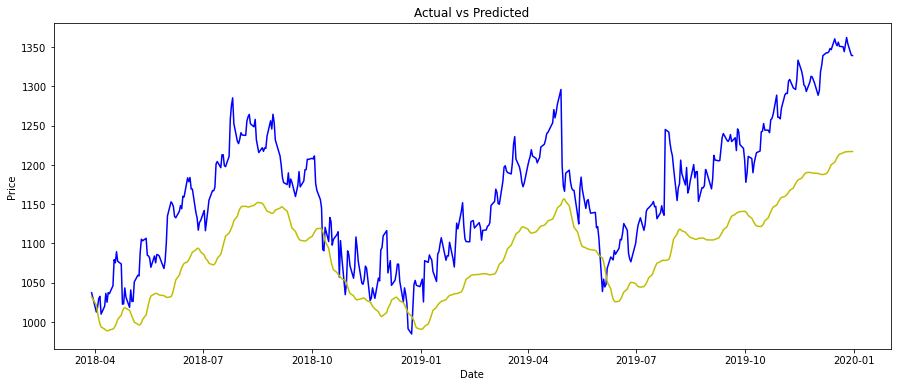

In [33]:
plt.figure(figsize=(15,6))
plt.plot(df['y_test'],color='b')
plt.plot(df['y_pred'],color='y')
plt.title("Actual vs Predicted")
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()